In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/cmu_lectures/cmu_optimal_control_course/lecturenotes/lecture_notes/Lecture 19/Project.toml`
   Installed MakieCore ───────────────── v0.6.3
   Installed TruncatedStacktraces ────── v1.3.0
   Installed GPUArraysCore ───────────── v0.1.4
   Installed SimpleNonlinearSolve ────── v0.1.14
   Installed FunctionWrappersWrappers ── v0.1.3
   Installed StaticArrayInterface ────── v1.3.0
   Installed LayoutPointers ──────────── v0.1.14
   Installed ExprTools ───────────────── v0.1.9
   Installed SymbolicIndexingInterface ─ v0.2.2
   Installed ChangesOfVariables ──────── v0.1.6
   Installed LoopVectorization ───────── v0.12.155
   Installed LinearSolve ─────────────── v1.41.0
   Installed StaticArrays ────────────── v1.5.19
   Installed CloseOpenIntervals ──────── v0.1.12
   Installed FastLapackInterface ─────── v1.2.9
   Installed ArrayInterface ──────────── v7.4.2
   Installed CPUSummary ──────────────── v0.2.2
   Installed PreallocationTools ──────── v0.4.12
   I

In [2]:
using LinearAlgebra
using PyPlot
using SparseArrays
using ControlSystems
using ForwardDiff

In [3]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]
C = [1.0 0]

1×2 Matrix{Float64}:
 1.0  0.0

In [4]:
# Noise Covariances
W = B*0.1*B' #Corresponds to white noise force input to dynamics
V = 0.1 #Noise on position measurements

0.1

In [6]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [7]:
# LQR Cost weights
Q = Array(1.0*I(n))
R = Array(0.1*I(m))
Qn = Q

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [8]:
# #Cost function
# function J(xhist,uhist)
#     cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
#     for k = 1:(size(xhist,2)-1)
#         cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
#     end
#     return cost
# end

In [9]:
#Infinite-Horizon LQR Gain and cost-to-go
# P = dare(A,B,Q,R)
K = dlqr(A,B,Q,R)

1×2 Matrix{Float64}:
 2.5857  3.44344

In [10]:
# Initial conditions
x0 = [1.0; 0] #True state

#Filter state
Σ0 = Array(1.0*I(2))
x̂0 = [0.0; 0.0]

2-element Vector{Float64}:
 0.0
 0.0

In [11]:
xhist = zeros(n,N)
xhist[:,1] .= x0;

uhist = zeros(N)
yhist = zeros(N)
x̂hist = zeros(n,N)
Σhist = zeros(n,n,N);

In [12]:
#Initial Time Step

#Generate Measurement
yhist[1] = (C*xhist[:,1])[1] + sqrt(V)*randn()

z = yhist[1] - (C*x̂0)[1] #Innovation
S = (C*Σ0*C')[1] + V #Innovation Covariance

L = Σ0*C'*inv(S) #Kalman Gain

x̂hist[:,1] = x̂0 + L*z
Σhist[:,:,1] .= (I-L*C)*Σ0*(I-L*C)' + L*V*L'

uhist[1] = -(K*x̂hist[:,1])[1] #Control input

xhist[:,2] .= A*xhist[:,1] + B*uhist[1] + sqrt(W)*randn(n) #Simulate with stochastic dynamics

2-element view(::Matrix{Float64}, :, 2) with eltype Float64:
  0.9911357147974902
 -0.1772857038253893

In [13]:
for k = 2:(N-1)
    
    #Generate measurement
    yhist[k] = (C*xhist[:,k])[1] + sqrt(V)*randn()

    #KF Update
    x̃ = A*x̂hist[:,k-1] + B*uhist[k-1] #State Prediction
    Σ̃ = A*Σhist[:,:,k-1]*A' + W #Covariance Prediction

    z = yhist[k] - (C*x̃)[1] #Innovation
    S = (C*Σ̃*C')[1] + V #Innovation Covariance

    L = Σ̃*C'*inv(S) #Kalman Gain

    x̂hist[:,k] = x̃ + L*z
    Σhist[:,:,k] = (I-L*C)*Σ̃*(I-L*C)' + L*V*L'

    #LQR Controller
    uhist[k] = -(K*x̂hist[:,k])[1]
    
    #Run this on the stochastic dynamics
    xhist[:,k+1] .= A*xhist[:,k] + B*uhist[k] + sqrt(W)*randn(n)
end

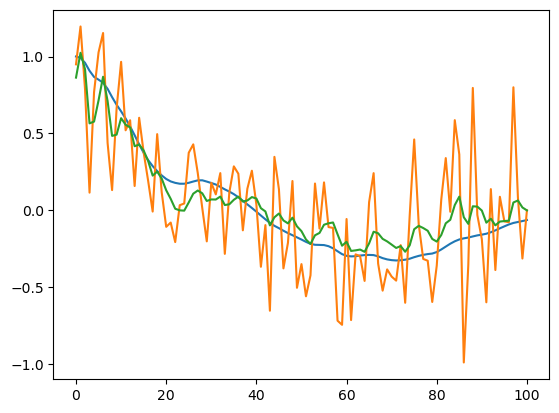

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff7c594b760>

In [17]:
plot(xhist[1,:],label="Line 1")
plot(yhist[:],label="Line 2")
plot(x̂hist[1,:],label="Line 3")

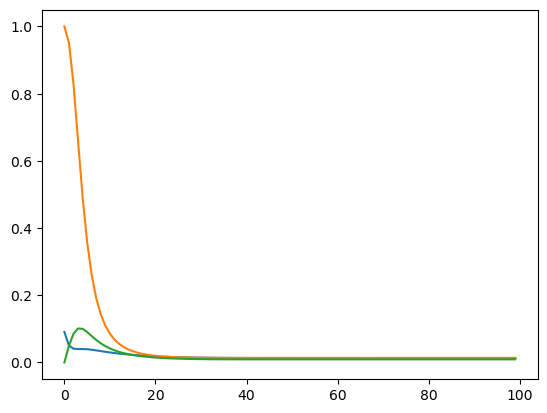

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ff7784e7760>

In [18]:
#Covariance and Kalman gain converge to steady-state values in the LTI case
#(just like LQR gain + cost-to-go Hessian)
plot(Σhist[1,1,1:N-1])
plot(Σhist[2,2,1:N-1])
plot(Σhist[1,2,1:N-1])